<a href="https://colab.research.google.com/github/Munfred/ACM104extra/blob/main/ACM104_extra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import io
import requests
import networkx as nx
import matplotlib.pyplot as plt
import operator
import random as rd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (5, 5)
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random


# Truncated SVD and PCA implementation compared with sklearn 









In [2]:

# We implement SVD using the power method following
# this reference: https://www.cs.princeton.edu/courses/archive/fall18/cos521/Lectures/lec14.pdf
# and this https://jeremykun.com/2016/05/16/singular-value-decomposition-part-2-theorem-proof-algorithm/


def make_random_unit_vector(d):
    random_vector= np.random.rand(d)
    random_unit_vector = random_vector/np.linalg.norm(random_vector)
    return random_unit_vector

def run_1d_power_method(A, num_iter=1000):
    n, d = A.shape
    vector = make_random_unit_vector(d)
    # calculate A^T*A for the pwoer method
    B = np.dot(np.transpose(A), A)
    # we just do an arbitrary number of iterations and hope it converges
    for i in range(num_iter):
        vector=np.dot(B, vector)
        #normalize the vector
        vector=vector/np.linalg.norm(vector)
    return vector

def svd(A):
    n, m = A.shape
    svd_list = []
 
    for i in range(m):
        A_copy = A.copy()
 
        for singularValue, u, v in svd_list[:i]:
            A_copy = A_copy -  singularValue * np.outer(u, v)
 
        v = run_1d_power_method(A_copy, num_iter=100)  # singular vector
        u = np.dot(A, v)/np.linalg.norm(np.dot(A, v))
        sigma = np.linalg.norm(np.dot(A, v))  # singular value
 
        svd_list.append((sigma, u, v))
 
    # transform it into matrices of the right shape
    singular_values, U, V = [np.array(x) for x in zip(*svd_list)]

    return singular_values, U.T, V


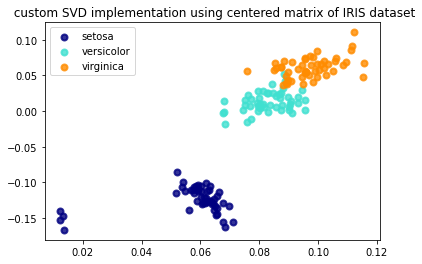

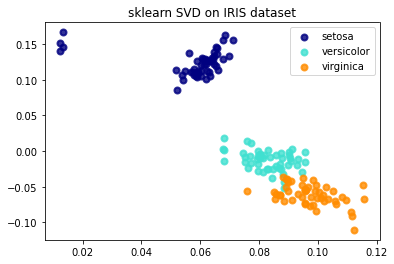

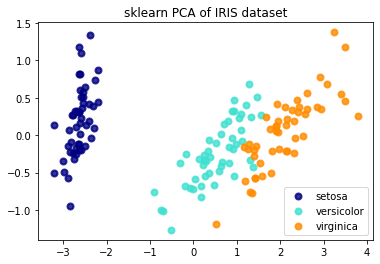

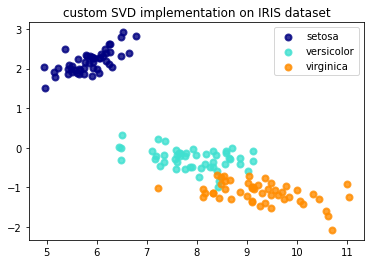

In [6]:
### plot SVD and PCA from sklearn on iris datast and compare with the manual SVD


iris = datasets.load_iris()

X = iris.data
iris_matrix = X
y = iris.target
target_names = iris.target_names

sklearn_svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X_sklearn_svd = sklearn_svd.fit(X).transform(X)


sklearn_pca = PCA(n_components=2)
X_r = sklearn_pca.fit(X).transform(X)

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

iris_matrix_centered= iris_matrix
for rownum in range(iris_matrix_centered.shape[1]):
    iris_matrix_centered[rownum]=iris_matrix_centered[rownum]-iris_matrix_centered[rownum].mean()

singular_values_PCA, U_SVD_iris_matrix_PCA, V_SVD_iris_matrix_PCA = svd(iris_matrix_centered)
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(U_SVD_iris_matrix_PCA[:,:2][y == i, 0], U_SVD_iris_matrix_PCA[:,:2][y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title(' custom SVD implementation using centered matrix of IRIS dataset')
plt.show()

singular_vlaues, U_SVD_iris_matrix, V_SVD_iris_matrix = svd(iris_matrix)
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(U_SVD_iris_matrix[:,:2][y == i, 0], U_SVD_iris_matrix[:,:2][y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('sklearn SVD on IRIS dataset')
plt.show()


for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('sklearn PCA of IRIS dataset')
plt.show()

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_sklearn_svd[:,:2][y == i, 0], X_sklearn_svd[:,:2][y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('custom SVD implementation on IRIS dataset')
plt.show()



#NMF implementation

In [7]:
#sklearn NMF
import numpy as np
X_sklearn = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X_sklearn)
H = model.components_
print('\n W = \n',W)
print('\n H = \n',H)


 W = 
 [[0.         0.46880684]
 [0.55699523 0.3894146 ]
 [1.00331638 0.41925352]
 [1.6733999  0.22926926]
 [2.34349311 0.03927954]
 [2.78981512 0.06911798]]

 H = 
 [[2.09783018 0.30560234]
 [2.13443044 2.13171694]]


In [8]:
# this code was adapted from the following resources
# https://www.youtube.com/watch?v=LJX5hdw-zUI
# https://www.ethanrosenthal.com/2017/06/20/matrix-factorization-in-pytorch/

import numpy as np
from scipy.sparse import rand as sprand
import torch


# X = np.random.randint(1, 10, size=(n_U,n_V))
X=X_sklearn
n_U = X.shape[0]
n_V = X.shape[1]
Xt = torch.tensor(X)
n_factors=2
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=n_factors):
        super().__init__()
        self.U_factors = torch.nn.Embedding(n_U, n_factors, sparse=False)
        self.V_factors = torch.nn.Embedding(n_V, n_factors, sparse=False)
        # initialize weights
        self.U_factors.weight.data.uniform_(0,0.05)
        self.V_factors.weight.data.uniform_(0,0.05)

    def forward(self, u, v):
        return (self.U_factors(u) * self.V_factors(v)).sum(1)

model = MatrixFactorization(n_U, n_V, n_factors=n_factors)
# to use frobenius norm as the loss function for each element, we can simply
# use the mean square error (squared L2 norm) between each element and the target
loss_func = torch.nn.MSELoss()


optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # learning rate
# had to increase the learning rate to get it to work in ~50 epochs, but works well now!

# Sort our data
rows, cols = X.nonzero()
p = np.random.permutation(len(rows))
rows, cols = rows[p], cols[p]

# we train for 50 epochs and see if we get reasonable results
for i in range(50):
    
    for row, col in zip(*(rows, cols)):
        # Set gradients to zero
        optimizer.zero_grad()
        
        # Turn data into tensors
        entry = torch.FloatTensor([X[row, col]])
        row = torch.LongTensor([row])
        col = torch.LongTensor([col])

        # Predict and calculate loss
        prediction = model(row, col)
        loss = loss_func(prediction, entry)
        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
    loss = loss_func(prediction, entry)
    print(loss)

tensor(8.9669, grad_fn=<MseLossBackward>)
tensor(8.8500, grad_fn=<MseLossBackward>)
tensor(8.3318, grad_fn=<MseLossBackward>)
tensor(6.2965, grad_fn=<MseLossBackward>)
tensor(1.6796, grad_fn=<MseLossBackward>)
tensor(0.0207, grad_fn=<MseLossBackward>)
tensor(0.0139, grad_fn=<MseLossBackward>)
tensor(0.0149, grad_fn=<MseLossBackward>)
tensor(0.0144, grad_fn=<MseLossBackward>)
tensor(0.0143, grad_fn=<MseLossBackward>)
tensor(0.0143, grad_fn=<MseLossBackward>)
tensor(0.0143, grad_fn=<MseLossBackward>)
tensor(0.0143, grad_fn=<MseLossBackward>)
tensor(0.0142, grad_fn=<MseLossBackward>)
tensor(0.0142, grad_fn=<MseLossBackward>)
tensor(0.0142, grad_fn=<MseLossBackward>)
tensor(0.0142, grad_fn=<MseLossBackward>)
tensor(0.0141, grad_fn=<MseLossBackward>)
tensor(0.0141, grad_fn=<MseLossBackward>)
tensor(0.0140, grad_fn=<MseLossBackward>)
tensor(0.0139, grad_fn=<MseLossBackward>)
tensor(0.0138, grad_fn=<MseLossBackward>)
tensor(0.0137, grad_fn=<MseLossBackward>)
tensor(0.0135, grad_fn=<MseLossBac

In [9]:
# print the original X
print(' \n Original X matrix \n',X)

# print the NMF factors multiplication results -- pretty close just by looking at the values! 
# I had to increase the learning rate to get it to work reasonably well within ~20 epochs
# training for more epochs yields a better decomposition!
print(' \n Reconstructed X matrix with pytorch optimizer: \n', torch.matmul(model.U_factors.weight,model.V_factors.weight.T))

print(' \n U matrix factors: \n', model.U_factors.weight)

print(' \n V matrix factors: \n', model.V_factors.weight)

 
 Original X matrix 
 [[1.  1. ]
 [2.  1. ]
 [3.  1.2]
 [4.  1. ]
 [5.  0.8]
 [6.  1. ]]
 
 Reconstructed X matrix with pytorch optimizer: 
 tensor([[1.0081, 0.9679],
        [2.0048, 0.9784],
        [3.0000, 1.1879],
        [3.9996, 1.0065],
        [5.0004, 0.8155],
        [6.0001, 1.0055]], grad_fn=<MmBackward>)
 
 U matrix factors: 
 Parameter containing:
tensor([[0.7864, 0.0912],
        [0.7326, 0.4701],
        [0.8537, 0.7877],
        [0.6313, 1.2262],
        [0.4003, 1.6682],
        [0.5040, 1.9935]], requires_grad=True)
 
 V matrix factors: 
 Parameter containing:
tensor([[0.9610, 2.7669],
        [1.2078, 0.1990]], requires_grad=True)


# Page rank implemmentaiton

done following http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html


In [130]:
A = np.array([[0,0,1,0.5],
             [1/3, 0,0, 0],
             [1/3,0.5,0,0.5],
             [1/3,0.5,0,0]])
A

array([[0.        , 0.        , 1.        , 0.5       ],
       [0.33333333, 0.        , 0.        , 0.        ],
       [0.33333333, 0.5       , 0.        , 0.5       ],
       [0.33333333, 0.5       , 0.        , 0.        ]])

In [131]:
v=np.array([0.25,0.25,0.25,0.25])
v

array([0.25, 0.25, 0.25, 0.25])

In [132]:
for n in [2, 5, 10, 20,100]:
    print(n)
    print(np.inner(np.linalg.matrix_power(A, n), v.T))


2
[0.4375     0.125      0.27083333 0.16666667]
5
[0.390625   0.13194444 0.28645833 0.19097222]
10
[0.38758681 0.12885802 0.29024402 0.19331115]
20
[0.38709616 0.12903205 0.29032302 0.19354877]
100
[0.38709677 0.12903226 0.29032258 0.19354839]


In [134]:
# naive page rank
print(A)
print(v)
Av = np.dot(A, v)
print('Av = ', Av)
for n in range(10):
    print(n)
    print(np.dot(np.linalg.matrix_power(A, n), Av))


[[0.         0.         1.         0.5       ]
 [0.33333333 0.         0.         0.        ]
 [0.33333333 0.5        0.         0.5       ]
 [0.33333333 0.5        0.         0.        ]]
[0.25 0.25 0.25 0.25]
Av =  [0.375      0.08333333 0.33333333 0.20833333]
0
[0.375      0.08333333 0.33333333 0.20833333]
1
[0.4375     0.125      0.27083333 0.16666667]
2
[0.35416667 0.14583333 0.29166667 0.20833333]
3
[0.39583333 0.11805556 0.29513889 0.19097222]
4
[0.390625   0.13194444 0.28645833 0.19097222]
5
[0.38194444 0.13020833 0.29166667 0.19618056]
6
[0.38975694 0.12731481 0.29050926 0.19241898]
7
[0.38671875 0.12991898 0.28978588 0.19357639]
8
[0.38657407 0.12890625 0.29065394 0.19386574]
9
[0.38758681 0.12885802 0.29024402 0.19331115]


In [137]:
# page rank with Google rank matrix M

B = 0.25* np.ones((4,4))

# lets do page rank with 3 values of damping factor
for p in [0.1, 0.2, 0.5]:
    print('damping factor:', p)
    M= (1-p)*A + p*B

    # naive page rank
    print('M=', M)

    Mv = np.dot(M, v)
    print('Mv = ', Mv)
    for n in range(10):
        print(n)
        print(np.dot(np.linalg.matrix_power(M, n), Mv))


damping factor: 0.1
M= [[0.025 0.025 0.925 0.475]
 [0.325 0.025 0.025 0.025]
 [0.325 0.475 0.025 0.475]
 [0.325 0.475 0.025 0.025]]
Mv =  [0.3625 0.1    0.325  0.2125]
0
[0.3625 0.1    0.325  0.2125]
1
[0.413125 0.13375  0.274375 0.17875 ]
2
[0.352375  0.1489375 0.2895625 0.209125 ]
3
[0.3797125  0.1307125  0.29184063 0.19773438]
4
[0.37663703 0.13891375 0.28671484 0.19773438]
5
[0.37202383 0.13799111 0.28948277 0.2005023 ]
6
[0.37576052 0.13660715 0.28892918 0.19870315]
7
[0.37445268 0.13772816 0.28861779 0.19920137]
8
[0.37439663 0.1373358  0.28895409 0.19931347]
9
[0.37474975 0.13731899 0.28881116 0.1991201 ]
damping factor: 0.2
M= [[0.05       0.05       0.85       0.45      ]
 [0.31666667 0.05       0.05       0.05      ]
 [0.31666667 0.45       0.05       0.45      ]
 [0.31666667 0.45       0.05       0.05      ]]
Mv =  [0.35       0.11666667 0.31666667 0.21666667]
0
[0.35       0.11666667 0.31666667 0.21666667]
1
[0.39       0.14333333 0.27666667 0.19      ]
2
[0.34733333 0.154 